In [66]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

import discretize
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG import (
    maps,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
)
from SimPEG.electromagnetics import frequency_domain as fdem

## Setup

In [67]:
sigma_surface = 1/1000
sigma_middle = 1/10
sigma_deep = 1/100
sigma_air = 1e-8

## Forward Modelling Mesh

the mesh has 15456 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_22524\732905370.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(core_domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_22524\732905370.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(core_domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

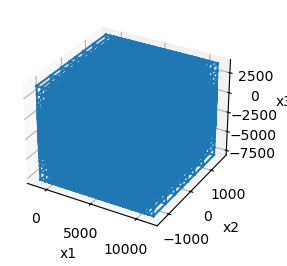

In [68]:
csx = 0.25e3  # cell size for the horizontal direction
csz = 0.125e3  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 3  # number of padding cells in the x-direction
npady = 3  # number of padding cells in the y-direction
npadz = 8  # number of padding cells in the z-direction

core_domain_x = np.r_[0.0, 10.0e3]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-4.0e3, 0.0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)

mesh.x0 = np.r_[
    -mesh.h[0][: npadx].sum(), -mesh.h[1][: npady].sum(), -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

## Inversion Mesh

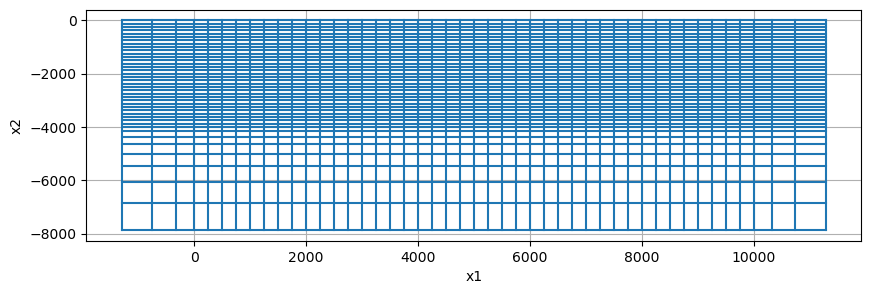

In [69]:
inversion_mesh = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh.x0 = [-inversion_mesh.h[0][mesh.cell_centers_x <= 0].sum(), -inversion_mesh.h[1].sum()]
ax = inversion_mesh.plot_grid()

## True Model

In [70]:
z_interface_shallow_top = -0.5e3
z_interface_deep_top = -1.0e3
x_dip_top = np.r_[5.0e3, 9.0e3]

z_interface_shallow_middle = -1.0e3
z_interface_deep_middle = -2.5e3
x_dip_middle = np.r_[2.0e3, 7.0e3]

In [71]:
def interface(x):
    # Top Interface
    interface_1 = np.zeros_like(x)
    interface_1[x < x_dip_top[0]] = z_interface_shallow_top
    dipping_unit_top = (x >= x_dip_top[0]) & (x <= x_dip_top[1])
    x_dipping_top = (-(z_interface_shallow_top - z_interface_deep_top) / (x_dip_top[1]- x_dip_top[0])) * (x[dipping_unit_top])
    x_dipping_top = x_dipping_top - x_dipping_top[0] + z_interface_shallow_top
    interface_1[dipping_unit_top] = x_dipping_top
    interface_1[x > x_dip_top[1]] = z_interface_deep_top

    # Middle Interface
    interface_2 = np.zeros_like(x)
    dipping_unit_middle = (x >= x_dip_middle[0]) & (x <= x_dip_middle[1])
    x_dipping_middle = (-(z_interface_shallow_middle - z_interface_deep_middle) / (x_dip_middle[1]-x_dip_middle[0])) * (x[dipping_unit_middle])
    x_dipping_middle = x_dipping_middle - x_dipping_middle[0] + z_interface_shallow_middle
    interface_2[dipping_unit_middle] = x_dipping_middle
    interface_2[x > x_dip_middle[1]] = z_interface_deep_middle

    return interface_1, interface_2

(-4000.0, 0.0)

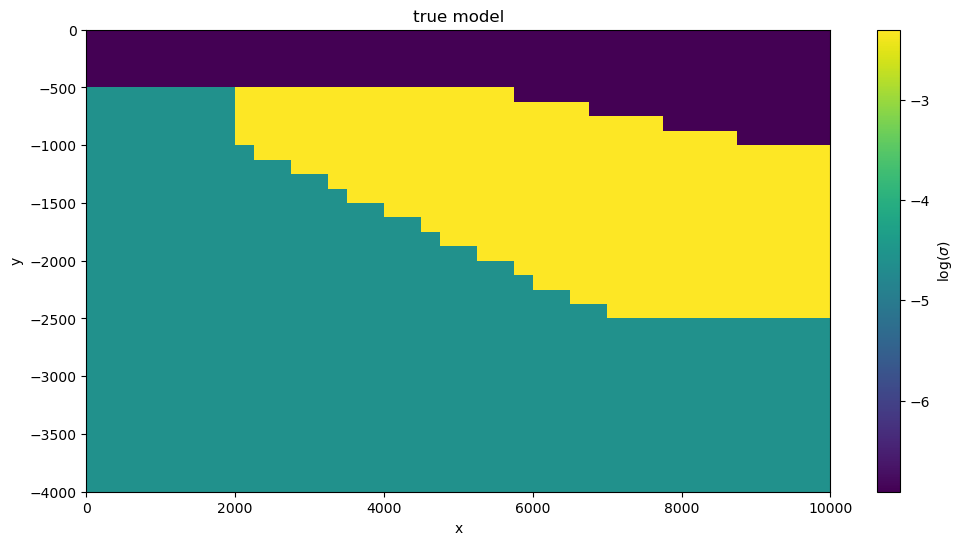

In [72]:
m_true = np.log(sigma_deep) * np.ones(inversion_mesh.nC)
interface_depth_1, interface_depth_2 = interface(inversion_mesh.gridCC[:, 0])
m_true[inversion_mesh.gridCC[:, 1] > interface_depth_2] = np.log(sigma_middle)
m_true[inversion_mesh.gridCC[:, 1] > interface_depth_1] = np.log(sigma_surface)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
cb = plt.colorbar(inversion_mesh.plot_image(m_true, ax=ax)[0], ax=ax)
cb.set_label(r"$\log(\sigma)$")
ax.set_title("true model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])
# ax.minorticks_on()
# ax.grid(True, which="both")

## Mapping

In [73]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


# 3D Mapping
mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, sigma_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh.nC
    )  # takes the exponential (log(sigma) --> sigma)
)

## Create Airborne Survey (?? Do I do this in 1D or 3D ??)

In [83]:
# Frequencies being predicted (10 Hz to 10000 Hz)
frequencies = np.logspace(-2, 6, 10)
sep = 10 # 10m separation
# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(np.arange(1000, 10000, 1000), [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(np.arange(1000, 10000, 1000) + sep, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(ntx):
    # Define receivers of different types at each location. Real and imaginary
    # measurements require separate receivers. You can define the orientation of
    # the transmitters and receivers for different survey geometries.
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )
    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]  # must be a list

    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list, frequencies[jj], source_locations[ii], orientation="z"
            )
        )

# create the survey and problem objects for running the forward simulation
survey = fdem.Survey(source_list)
prob = fdem.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=mapping, solver=Solver
)